In [1]:
!pip install xgboost
!pip install joblib
!pip install imblearn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [381]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter

def plot_correlation_matrix(data):
    """
    Calcula y muestra la matriz de correlación del dataset.

    Parameters:
    data (pd.DataFrame): Dataset para calcular la matriz de correlación.
    """
    corr_matrix = data.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
    plt.title("Matriz de Correlación")
    plt.show()

def calculate_veredict_percentages(data, veredict_column='Veredict'):
    """
    Calcula y muestra el porcentaje de valores positivos y negativos en la columna 'Veredict' de un DataFrame.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        veredict_column (str): El nombre de la columna que contiene los valores de veredicto. Por defecto es 'Veredict'.

    Returns:
        dict: Un diccionario con los porcentajes de valores positivos y negativos.
    """
    veredict_counts = data[veredict_column].value_counts()

    total = veredict_counts.sum()
    positive_percentage = (veredict_counts[1] / total) * 100
    negative_percentage = (veredict_counts[0] / total) * 100

    print(f'Porcentaje de "{veredict_column}" positivo: {positive_percentage:.2f}%')
    print(f'Porcentaje de "{veredict_column}" negativo: {negative_percentage:.2f}%')

    return {
        'positive_percentage': positive_percentage,
        'negative_percentage': negative_percentage
    }

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.

    Parameters:
    - conf_matrix: array-like, shape = [n_classes, n_classes]
      Confusion matrix to be plotted.
    - class_names: list of strings
      Class names for the confusion matrix.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model, oversample=False):
    """
      Trains and evaluates a machine learning model on given training, validation, and test datasets.

      Parameters:
      - X_train: array-like of shape (n_samples, n_features)
      - y_train: array-like of shape (n_samples,)
      - X_val: array-like of shape (n_samples, n_features)
      - y_val: array-like of shape (n_samples,)
      - X_test: array-like of shape (n_samples, n_features)
      - y_test: array-like of shape (n_samples,)
      - model: object
      - oversample: bool, default=False
        If True, applies SMOTE (Synthetic Minority Over-sampling Technique) to balance the training dataset.

      Returns:
      - accuracy_train: float Accuracy of the model on the training set.
      - accuracy_val: float Accuracy of the model on the validation set.
      - accuracy_test: float  Accuracy of the model on the test set.
      - cross_val: float Mean cross-validation accuracy of the model on the training set.
      - conf_matrix: array-like of shape (n_classes, n_classes) Confusion matrix of the model on the test set.
      - class_report: string

      Classification report of the model on the test set, including precision, recall, f1-score for each class.
    """
    if oversample:
        # counter = Counter(y_train)
        # print("Before", counter)
        smt = SMOTE()
        X_train, y_train = smt.fit_resample(X_train, y_train)
        X_val, y_val = smt.fit_resample(X_val, y_val)
        model.fit(X_train, y_train)
        # counter = Counter(y_train)
        # print("After", counter)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    cross_val = abs(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean())

    model.fit(X_train, y_train)  # Reentrenar el modelo con el conjunto de entrenamiento completo
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_report = classification_report(y_test, y_pred_test)

    return accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report

def print_evaluation_results(accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report):
    """
      Prints the evaluation results of a machine learning model.

      Parameters:
      - accuracy_train: float Accuracy of the model on the training set.
      - accuracy_val: float  Accuracy of the model on the validation set.
      - accuracy_test: float  Accuracy of the model on the test set.
      - cross_val: float Mean cross-validation accuracy of the model on the training set.
      - conf_matrix: array-like of shape (n_classes, n_classes) Confusion matrix of the model on the test set.
      - class_report: string Classification report of the model on the test set, including precision, recall, f1-score for each class.
    """
    print("Training set accuracy:", accuracy_train)
    print("Validation set accuracy:", accuracy_val)
    print("Test set accuracy:", accuracy_test)
    print("\nCross-validation set accuracy:", cross_val)
    print('\nClassification Report for the test set:')
    print(class_report)
    print('Confusion Matrix for the test set:')

    class_names = ['No Plagio', 'Plagio']
    plot_confusion_matrix(conf_matrix, class_names)

def perform_grid_search(X_train, y_train, param_grid):
    """
      Performs a grid search to find the best hyperparameters for an XGBoost classifier.

      Parameters:
      - X_train: array-like of shape (n_samples, n_features)  Training input samples.
      - y_train: array-like of shape (n_samples,) Target values (class labels) for the training input samples.
      - param_grid: dict or list of dictionaries

      Returns:
      - best_params_: dict Parameter setting that gave the best results on the hold out data.
      - best_estimator_: estimator object Estimator that was chosen by the search, i.e., estimator which gave highest score
    """
    xgb_model = xgb.XGBClassifier(reg_lambda=0.1)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_estimator_

def print_predictions(predictions, real_values):
    """
    Prints the predictions along with the real values and the percentage of correct predictions.

    Parameters:
    - predictions: array-like of shape (n_samples,)
      The predicted classes for the input samples.
    - real_values: array-like of shape (n_samples,)
      The actual classes for the input samples.
    """
    correct_predictions = sum(predictions == real_values)
    total_predictions = len(predictions)
    accuracy_percentage = (correct_predictions / total_predictions) * 100

    print("Predicciones vs Valores Reales:")
    print("=" * 40)
    for idx, (prediction, real_value) in enumerate(zip(predictions, real_values), start=1):
        print(f"Predicción {idx}: {prediction} (Valor Real: {real_value})")
    print("=" * 40)
    print(f"Porcentaje de predicciones correctas: {accuracy_percentage:.2f}%")

data_train = pd.read_csv("preprocessed_data/v3/train_3.csv")
data_val = pd.read_csv("preprocessed_data/v3/val_3.csv")
data_test = pd.read_csv("preprocessed_data/v3/test_3.csv")
querie = pd.read_csv("preprocessed_data/v3/queries_3.csv")

In [382]:
def load_model_and_predict(input_data):
    """
      Loads a pre-trained model from a file and uses it to make predictions on the provided input data.

      Parameters:
      - input_data: array-like of shape (n_samples, n_features)
        The input samples for which predictions are to be made.

      Returns:
      - predictions: array-like of shape (n_samples,)
        The predicted classes for the input samples.
    """
    model = joblib.load('model.pkl')
    predictions = model.predict(input_data)
    return predictions

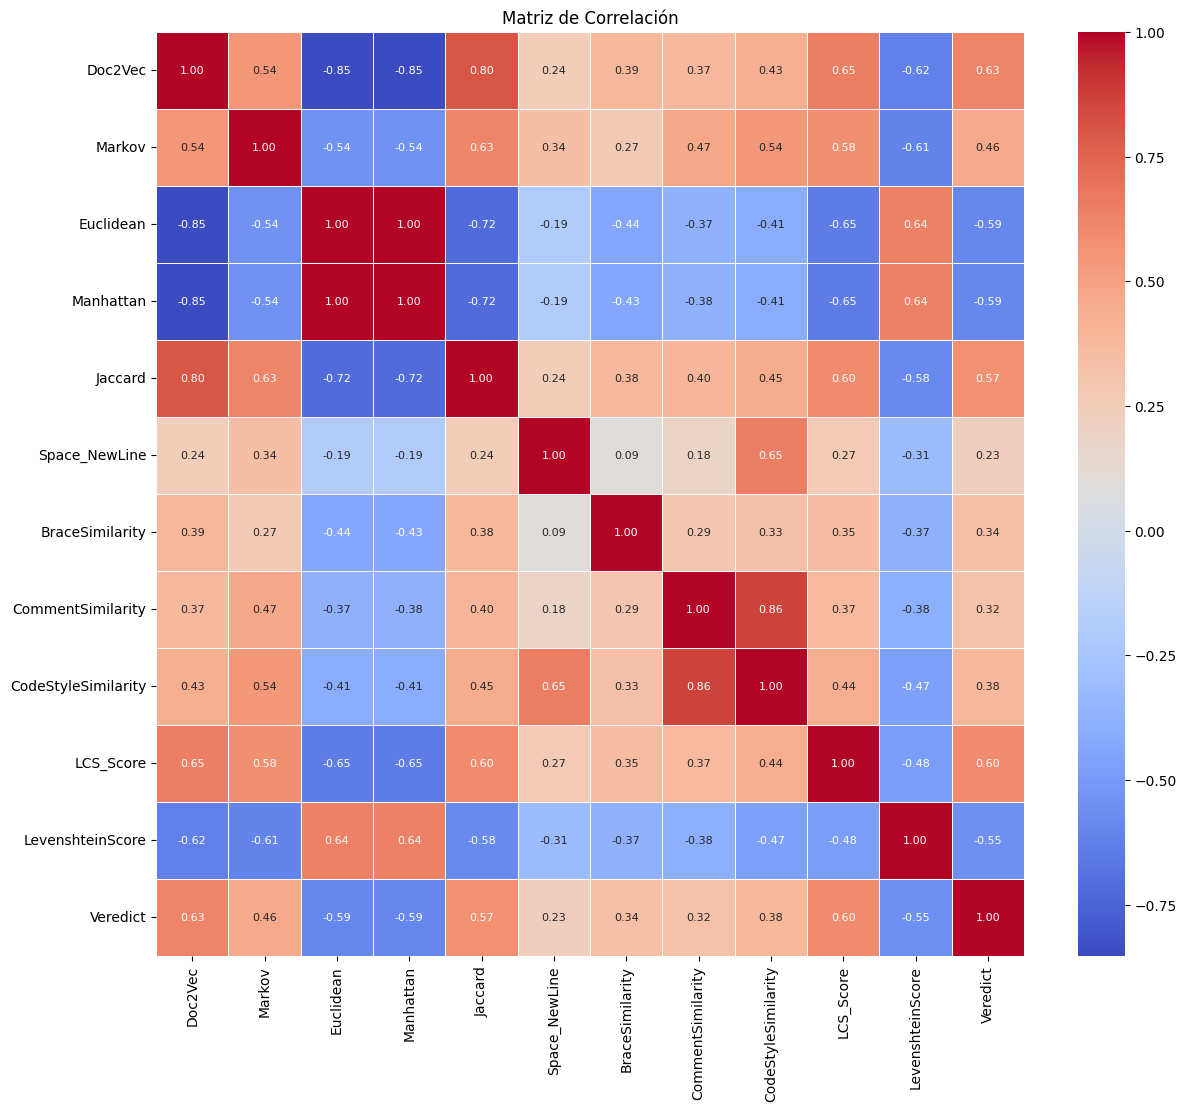

In [383]:
plot_correlation_matrix(data_train)

In [384]:
X_train = data_train.drop(columns=['Veredict'])
y_train = data_train['Veredict']

X_val = data_val.drop(columns=['Veredict'])
y_val = data_val['Veredict']

X_test = data_test.drop(columns=['Veredict'])
y_test = data_test['Veredict']

real_values = querie['Veredict']
querie = querie.drop(columns=['Veredict'])

# Modelos

### OverSAMPLING


Training set accuracy: 1.0
Validation set accuracy: 0.9090909090909091
Test set accuracy: 0.912568306010929

Cross-validation set accuracy: 0.8776212085025078

Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       132
           1       0.86      0.82      0.84        51

    accuracy                           0.91       183
   macro avg       0.89      0.89      0.89       183
weighted avg       0.91      0.91      0.91       183

Confusion Matrix for the test set:


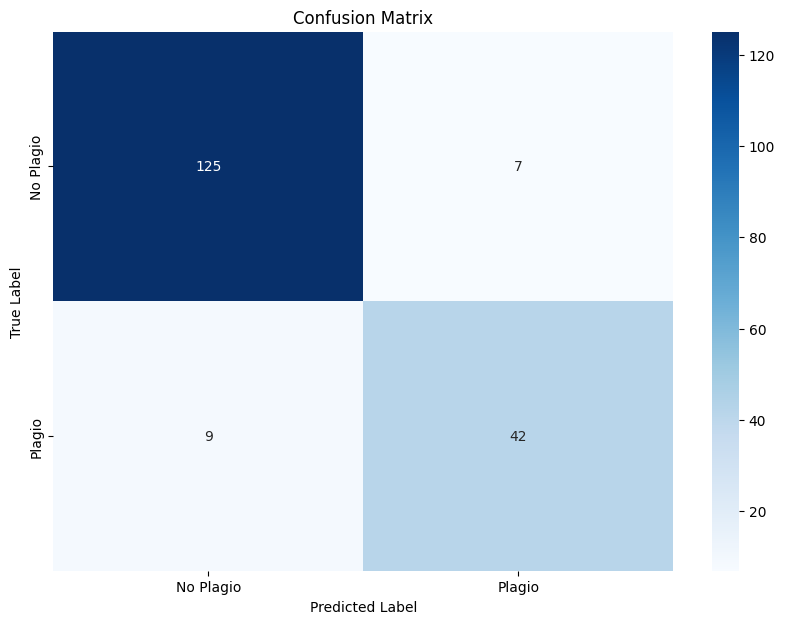

In [425]:
model_os = xgb.XGBClassifier()
accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_os, oversample=True)
print_evaluation_results(accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report)

In [426]:
joblib.dump(model_os, 'model.pkl')

['model.pkl']

### Sin OVERSAMPLING

Training set accuracy: 1.0
Validation set accuracy: 0.9065934065934066
Test set accuracy: 0.8797814207650273

Cross-validation set accuracy: 0.844303586321935

Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       132
           1       0.85      0.69      0.76        51

    accuracy                           0.88       183
   macro avg       0.87      0.82      0.84       183
weighted avg       0.88      0.88      0.88       183

Confusion Matrix for the test set:


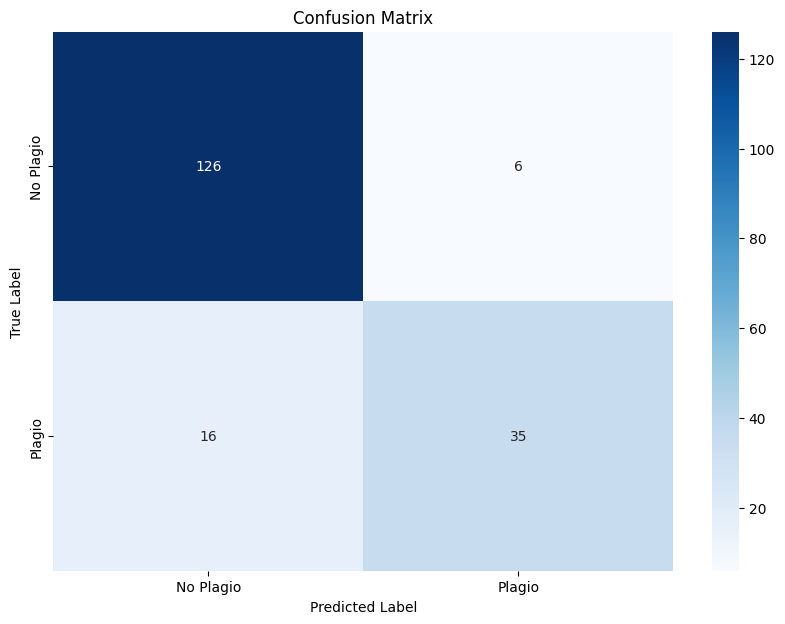

In [215]:
model_wo_os = xgb.XGBClassifier()
accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_wo_os, oversample=False)
print_evaluation_results(accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report)


### Ajuste del peso de clase

Training set accuracy: 1.0
Validation set accuracy: 0.9340659340659341
Test set accuracy: 0.8852459016393442

Cross-validation set accuracy: 0.857164303586322

Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       132
           1       0.86      0.71      0.77        51

    accuracy                           0.89       183
   macro avg       0.88      0.83      0.85       183
weighted avg       0.88      0.89      0.88       183

Confusion Matrix for the test set:


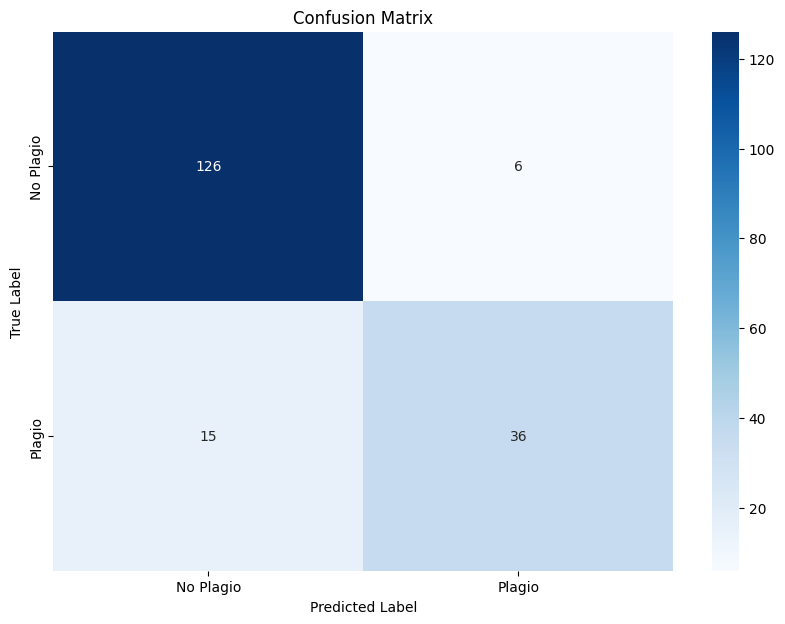

In [186]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

model = xgb.XGBClassifier(reg_lambda=0.1, scale_pos_weight=scale_pos_weight)
accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model, oversample=False)
print_evaluation_results(accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report)

### GridSearch XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training set accuracy: 1.0
Validation set accuracy: 0.9120879120879121
Test set accuracy: 0.8907103825136612

Cross-validation set accuracy: 0.8700083402835697

Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       132
           1       0.86      0.73      0.79        51

    accuracy                           0.89       183
   macro avg       0.88      0.84      0.86       183
weighted avg       0.89      0.89      0.89       183

Confusion Matrix for the test set:


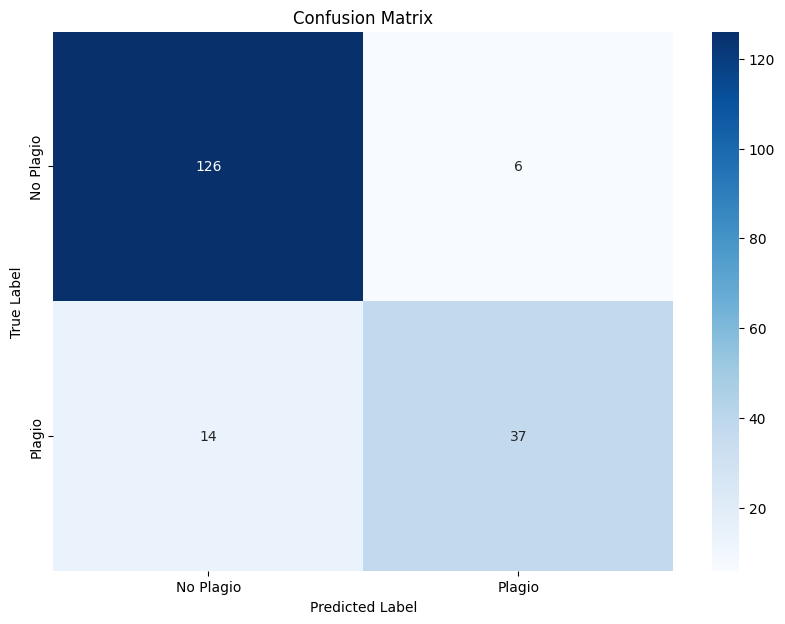

In [188]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, best_model, oversample=False)
print_evaluation_results(accuracy_train, accuracy_val, accuracy_test, cross_val, conf_matrix, class_report)


### Gridsearch Random Forest

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training set accuracy: 0.9047619047619048
Validation set accuracy: 0.9065934065934066
Test set accuracy: 0.8961748633879781

Cross-validation set accuracy: 0.8846371976647205

Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       132
           1       0.97      0.65      0.78        51

    accuracy                           0.90       183
   macro avg       0.92      0.82      0.85       183
weighted avg       0.90      0.90      0.89       183

Confusion Matrix for the test set:


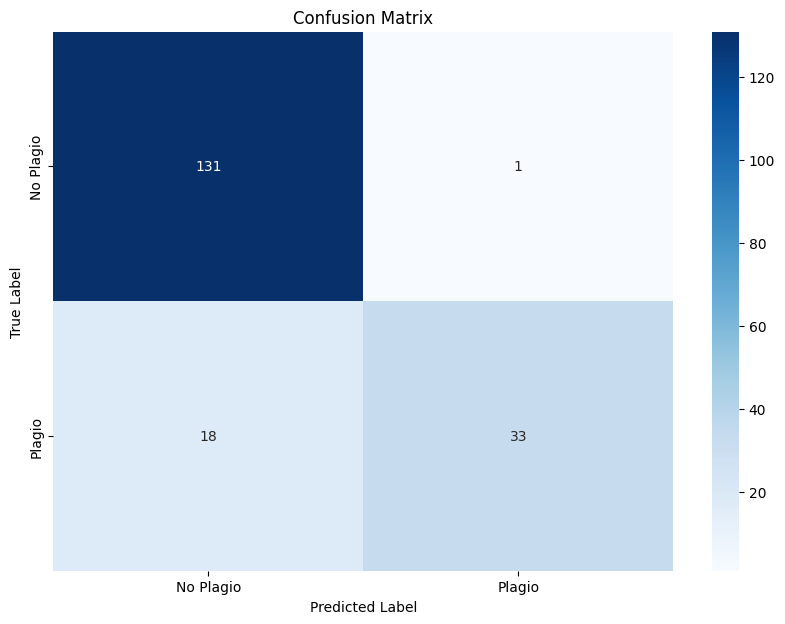

In [191]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model_rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

accuracy_train_rf, accuracy_val_rf, accuracy_test_rf, cross_val_rf, conf_matrix_rf, class_report_rf = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, best_model_rf, oversample=False)
print_evaluation_results(accuracy_train_rf, accuracy_val_rf, accuracy_test_rf, cross_val_rf, conf_matrix_rf, class_report_rf)

In [199]:
predictions = model_wo_os.predict(querie)
print_predictions(predictions, real_values)

Predicciones vs Valores Reales:
Predicción 1: 1 (Valor Real: 1)
Predicción 2: 1 (Valor Real: 1)
Predicción 3: 0 (Valor Real: 1)
Predicción 4: 1 (Valor Real: 1)
Predicción 5: 1 (Valor Real: 1)
Predicción 6: 0 (Valor Real: 0)
Predicción 7: 0 (Valor Real: 0)
Predicción 8: 1 (Valor Real: 0)
Predicción 9: 0 (Valor Real: 0)
Predicción 10: 1 (Valor Real: 0)
Porcentaje de predicciones correctas: 70.00%
